# Model Building

## Importing the necessary Libaries

In [1]:
import os # For interacting with the operating system
import torch # PyTorch library for tensor computations
import torch.nn as nn # Neural network components in PyTorch
import torch.optim as optim # Optimization algorithms in PyTorch
import torchvision.transforms as transforms # Image transformation utilities
import torchvision.datasets as datasets # Predefined image datasets from torchvision
from torch.utils.data import DataLoader, random_split # For data loading and splitting
from google.colab import drive # To mount Google Drive in Colab
from PIL import Image # Python Imaging Library for image processing
import matplotlib.pyplot as plt # Plotting library for visualizations
import torch.nn.functional as F # for activation functions, pooling, etc.
import time # to measure training duration

## Connecting with google drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


##  Setting Random Seed and Device Configuration

To ensure consistent results and use the best available hardware (GPU if available), I set a fixed random seed and check for GPU availability.

In [3]:
# Sets random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Transformations

I applied transformations to prepare the images for training a CNN model. First, I used ToTensor() to convert images into PyTorch tensors and scale pixel values to the range [0, 1]. Then, I used Normalize() to standardize the data with a fixed mean and standard deviation, which helps the model train faster and more reliably.

In [4]:
# Define transformations
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])


## Loading Datasets

In [5]:
dataset_dir = '/content/drive/MyDrive/Processed_plants'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)


## Spliting Dataset into traning and testing

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


## Data Loader

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Checking sizes

In [8]:
print(f"Train size: {len(train_dataset)} images")
print(f"Test size: {len(test_dataset)} images")


Train size: 1037 images
Test size: 260 images


## Visualizing Sample Plant Images

  I define a simple function to denormalize the images by reversing the normalization applied during preprocessing. Then, I use this function to visualize a batch of grayscale images from the training set. Displaying denormalized images helps me see the actual image intensity values clearly and verify that the data looks correct before training the model.

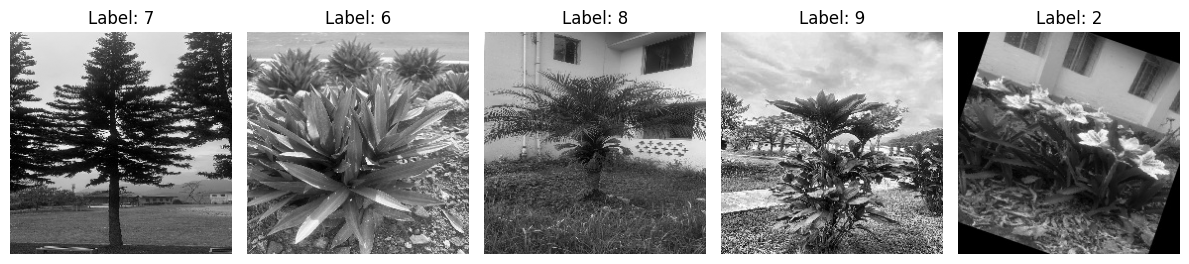

In [ ]:
def denormalize(tensor, mean=0.1307, std=0.3081):
    # Reverse the normalization to get original image pixel values
    tensor = tensor * std + mean
    # Clamp values to be between 0 and 1 for valid image display
    tensor = tensor.clamp(0, 1)
    return tensor

# Example usage to display a batch of images
examples = iter(train_loader)
samples, labels = next(examples)

plt.figure(figsize=(12, 5))
for i in range(5):
    img = denormalize(samples[i][0])  # Get 1st channel (grayscale)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Model 1: Simple Convolutional Neural Network

This model is a basic Convolutional Neural Network (CNN) designed to classify grayscale images of plants into 10 different categories. It uses two convolutional layers followed by max pooling and two fully connected layers. The final layer outputs a probability distribution over the 10 plant classes using log-softmax, making it suitable for multi-class classification tasks. This model serves as a simple yet effective baseline for image classification.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):  # Pass number of output classes
        super(SimpleCNN, self).__init__()

        # First conv layer: input 3 channels (RGB), output 16 channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Adaptive pool ensures fixed-size output regardless of input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 56, 56]
        x = self.adaptive_pool(x)             # [B, 32, 4, 4]
        x = x.view(x.size(0), -1)             # Flatten to [B, 32*4*4]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x


## Model 2: Improved CNN Model (CNN with Dropout)

This model is an improved convolutional neural network designed to better learn complex features from grayscale plant images.

- **Architecture:** It contains two convolutional layers with increased filter sizes (32 and 64 filters) to capture more detailed patterns.
- **Regularization:** Dropout layers are added after the convolutional layers and the first fully connected layer to reduce overfitting.
- **Activation:** ReLU activations introduce non-linearity.
- **Output:** The final layer outputs log probabilities over 10 classes using log softmax.




In [10]:
# Define a ImprovedCNN architecture
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # First convolutional layer: input RGB images (3 channels), output 32 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # Second convolutional layer: input 32, output 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer (reduces spatial dimension by half)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional layer: input 64, output 128 feature maps
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fourth convolutional layer: input 128, output 128 feature maps
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layer to reduce overfitting (applied before FC layers)
        self.dropout = nn.Dropout(0.5)

        # After two pooling layers, input image size 224x224 becomes 56x56
        # So flattened feature size after conv4 = 128 * 56 * 56
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 10)              # Output layer for 10 classes

    def forward(self, x):
        # Apply first conv layer + ReLU + MaxPool
        x = self.pool(self.relu(self.conv1(x)))

        # Apply second conv layer + ReLU + MaxPool
        x = self.pool(self.relu(self.conv2(x)))

        # Apply third and fourth conv layers + ReLU (no pooling)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)  # Shape becomes [batch_size, 128*56*56]

        # Apply fully connected layers with dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  # Output layer (no activation here as CrossEntropyLoss handles it)

        return x


## Model 3: Deep CNN with Batch Normalization

This model is a deeper convolutional neural network designed to extract rich features from plant images by stacking three convolutional blocks.

- **Batch Normalization:** Applied after each convolution to stabilize training and speed up convergence.
- **Dropout:** Used after convolutional blocks and fully connected layers to prevent overfitting.
- **Architecture:** Three convolutional layers with increasing filter sizes (32, 64, 128) and max pooling for spatial downsampling.
- **Output:** Classifies input images into 10 classes using log softmax activation.

This model is more complex and suitable for capturing intricate patterns in images, making it ideal for datasets requiring higher representational capacity.


In [11]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: [B, 1, 28, 28] → Output: [B, 32, 28, 28]
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: [B, 64, 14, 14]
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial size by half
        self.dropout = nn.Dropout2d(0.25)

        # Fix shape to [B, 64, 7, 7] before flattening using Adaptive Pool
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 32, 14, 14]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 64, 7, 7]
        x = self.adaptive_pool(x)                       # Ensure fixed size
        x = self.dropout(x)
        x = x.view(x.size(0), -1)                       # Flatten for FC
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training and Evaluation of CNN Models

 Training and evaluation functions are used to train the three CNN models on the dataset. The models are trained for multiple epochs, and after each epoch, both training and testing losses and accuracies are calculated. The performance metrics are stored and visualized to compare the effectiveness of each model.

These functions help in:
- Optimizing the model weights using backpropagation.
- Monitoring how well the model learns (loss and accuracy).
- Preventing overfitting by evaluating on a separate test set.


In [12]:
# Training function
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()       # Clear gradients
        outputs = model(data)       # Forward pass
        loss = criterion(outputs, target)  # Compute loss
        loss.backward()             # Backpropagation
        optimizer.step()            # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)  # Get predicted class
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Evaluation function for validation/testing
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)         # Forward pass
            loss = criterion(outputs, target)  # Compute loss

            running_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Function to plot training and testing history
def plot_history(train_losses, test_losses, train_accs, test_accs, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Hyperparameters
epochs = 5
learning_rate = 0.01

results = {}  # To store training/testing results for each model


# Training Model 1 - Simple CNN

In [30]:
# Training Model 1 - Simple CNN
print("="*50)
print("Training Model 1: Simple CNN")
print("="*50)

# Initialize the SimpleCNN model and move to device (CPU or GPU)
model1 = SimpleCNN().to(device)

# Define optimizer (SGD with momentum) and loss function (cross-entropy)
optimizer = optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Lists to store training and testing history for plotting later
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Start timer for training duration
start_time = time.time()

# Loop over the number of epochs to train the model
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model1, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model1, test_loader, criterion, device)

    # Store history after each epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Calculate and print total training time
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Training Model 1: Simple CNN
Epoch 1/10: Train Loss: 2.2970, Train Acc: 10.61%, Test Loss: 2.2957, Test Acc: 8.08%
Epoch 2/10: Train Loss: 2.2633, Train Acc: 12.92%, Test Loss: 2.2492, Test Acc: 24.62%
Epoch 3/10: Train Loss: 2.0484, Train Acc: 24.49%, Test Loss: 1.8873, Test Acc: 36.92%
Epoch 4/10: Train Loss: 1.8564, Train Acc: 34.33%, Test Loss: 1.7356, Test Acc: 38.08%
Epoch 5/10: Train Loss: 1.7635, Train Acc: 36.64%, Test Loss: 1.6375, Test Acc: 43.85%
Epoch 6/10: Train Loss: 1.6142, Train Acc: 40.60%, Test Loss: 1.6979, Test Acc: 36.15%
Epoch 7/10: Train Loss: 1.5712, Train Acc: 43.30%, Test Loss: 1.5895, Test Acc: 50.77%
Epoch 8/10: Train Loss: 1.4181, Train Acc: 50.43%, Test Loss: 1.5073, Test Acc: 50.00%
Epoch 9/10: Train Loss: 1.3433, Train Acc: 51.21%, Test Loss: 1.4586, Test Acc: 56.54%
Epoch 10/10: Train Loss: 1.2892, Train Acc: 53.23%, Test Loss: 1.3932, Test Acc: 53.85%
Training time: 59.77 seconds


## Visualizing and Saving Training Results for Simple CNN

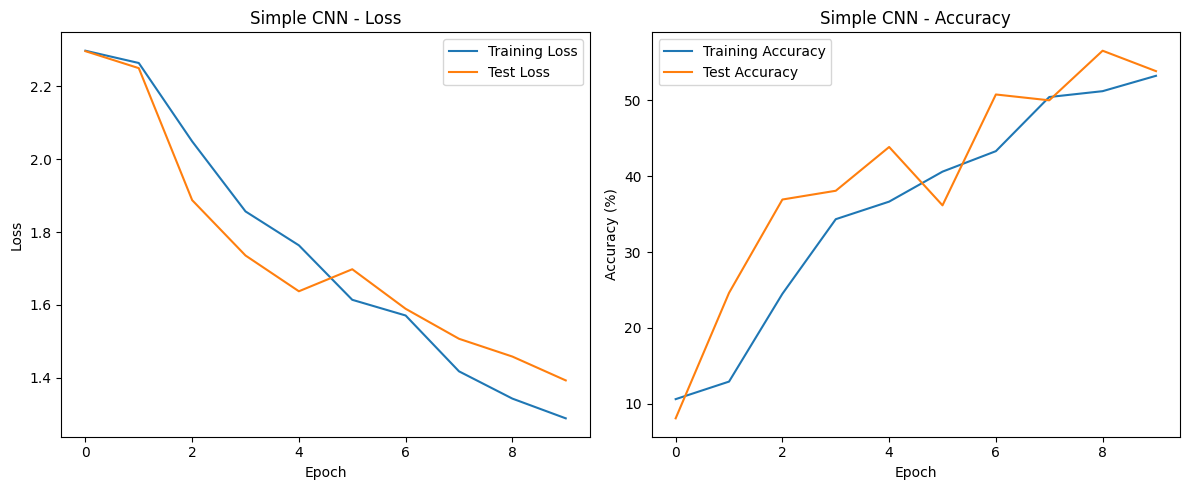

In [31]:
# show the loss and accuracy over epochs for both training and test sets
plot_history(train_losses, test_losses, train_accs, test_accs, "Simple CNN")

# Saves the final accuracy and training time of the Simple CNN model in a dictionary for later comparison
results["Simple CNN"] = {
    "final_train_acc": train_accs[-1],  # Final training accuracy
    "final_test_acc": test_accs[-1],    # Final test accuracy
    "training_time": training_time      # Total training time
}

## Training Model 2 - Improved CNN

In [32]:
# Print header
print("=" * 50)
print("Training Model 2: Improved CNN")
print("=" * 50)

# Initialize model and move to device (CPU or GPU)
model2 = ImprovedCNN().to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Lists to store training history
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Start timer for training duration
start_time = time.time()

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model2, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model2, test_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Total training time
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Training Model 2: Improved CNN
Epoch 1/10: Train Loss: 2.2680, Train Acc: 13.69%, Test Loss: 2.0019, Test Acc: 23.85%
Epoch 2/10: Train Loss: 1.9346, Train Acc: 30.76%, Test Loss: 1.5616, Test Acc: 42.69%
Epoch 3/10: Train Loss: 1.5838, Train Acc: 43.68%, Test Loss: 1.3927, Test Acc: 52.31%
Epoch 4/10: Train Loss: 1.4224, Train Acc: 47.25%, Test Loss: 1.1978, Test Acc: 55.38%
Epoch 5/10: Train Loss: 1.3488, Train Acc: 52.07%, Test Loss: 1.2565, Test Acc: 63.08%
Epoch 6/10: Train Loss: 1.1503, Train Acc: 59.79%, Test Loss: 1.1693, Test Acc: 63.08%
Epoch 7/10: Train Loss: 1.1676, Train Acc: 59.79%, Test Loss: 1.3981, Test Acc: 46.54%
Epoch 8/10: Train Loss: 0.9967, Train Acc: 66.25%, Test Loss: 1.5274, Test Acc: 50.38%
Epoch 9/10: Train Loss: 0.9187, Train Acc: 69.33%, Test Loss: 0.9890, Test Acc: 73.08%
Epoch 10/10: Train Loss: 0.8287, Train Acc: 73.19%, Test Loss: 0.8758, Test Acc: 70.77%
Training time: 85.77 seconds


## Visualizing and Saving Training Results for Improved CNN

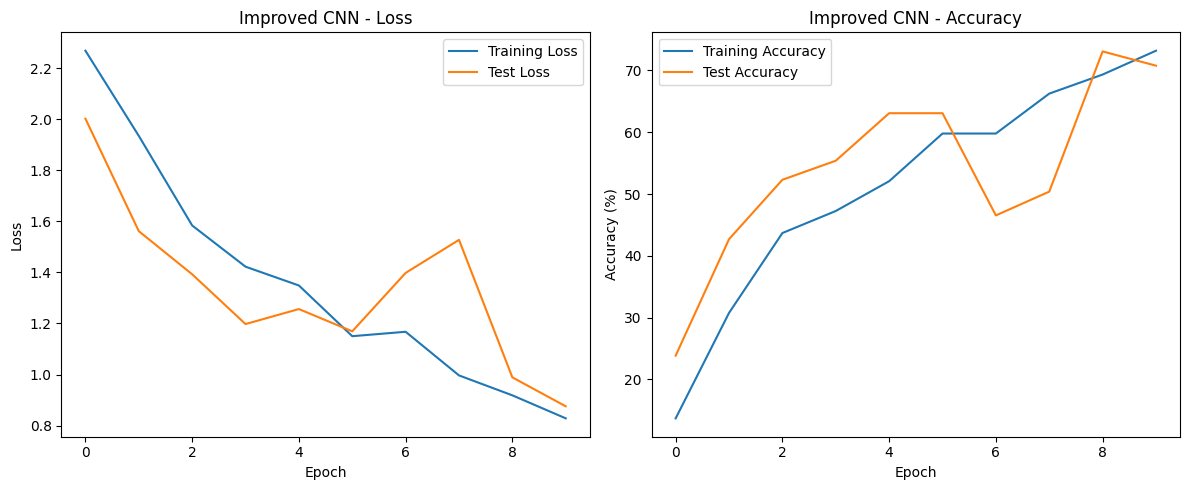

In [33]:
# show the loss and accuracy over epochs for both training and test sets
plot_history(train_losses, test_losses, train_accs, test_accs, "Improved CNN")

# Saves the final accuracy and training time of the Improved CNN model in a dictionary for later comparison
results["Improved CNN"] = {
    "final_train_acc": train_accs[-1],  # Final training accuracy
    "final_test_acc": test_accs[-1],    # Final test accuracy
    "training_time": training_time      # Total training time
}

## Training Model 3 - Deep CNN

In [37]:
print("\n" + "="*50)
print("Training Model 3: Deep CNN")
print("="*50)

# Initialize model, optimizer, and loss function
model3 = DeepCNN().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Lists to track history
train_losses, test_losses = [], []
train_accs, test_accs = [], []

epochs = 10
start_time = time.time()

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model3, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model3, test_loader, criterion, device)

    # Save losses and accuracies
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

training_time = time.time() - start_time
print(f"Training complete in {training_time:.2f} seconds.")


Training Model 3: Deep CNN
Epoch 1/10: Train Loss: 1.9698, Train Acc: 29.51%, Test Loss: 1.4414, Test Acc: 51.54%
Epoch 2/10: Train Loss: 1.3409, Train Acc: 54.00%, Test Loss: 1.0026, Test Acc: 64.62%
Epoch 3/10: Train Loss: 1.0072, Train Acc: 64.61%, Test Loss: 0.9544, Test Acc: 73.85%
Epoch 4/10: Train Loss: 0.7609, Train Acc: 74.06%, Test Loss: 0.7581, Test Acc: 77.31%
Epoch 5/10: Train Loss: 0.7210, Train Acc: 73.77%, Test Loss: 0.9788, Test Acc: 68.46%
Epoch 6/10: Train Loss: 0.5659, Train Acc: 79.36%, Test Loss: 0.8188, Test Acc: 75.77%
Epoch 7/10: Train Loss: 0.4989, Train Acc: 81.87%, Test Loss: 0.8258, Test Acc: 73.46%
Epoch 8/10: Train Loss: 0.3921, Train Acc: 86.69%, Test Loss: 0.6378, Test Acc: 79.23%
Epoch 9/10: Train Loss: 0.2924, Train Acc: 90.16%, Test Loss: 0.6095, Test Acc: 83.08%
Epoch 10/10: Train Loss: 0.2916, Train Acc: 89.59%, Test Loss: 0.4157, Test Acc: 86.54%
Training complete in 71.74 seconds.


## Visualizing and Saving Training Results for Deep CNN

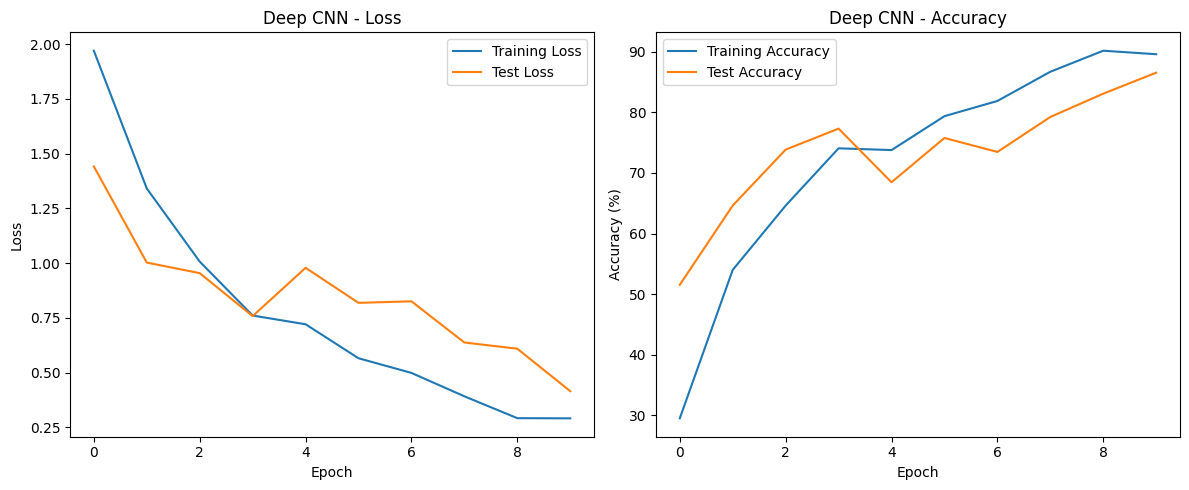

In [38]:
# Plot training history
plot_history(train_losses, test_losses, train_accs, test_accs, "Deep CNN")
# Store results
results["Deep CNN"] = {
"final_train_acc": train_accs[-1],
"final_test_acc": test_accs[-1],
"training_time": training_time
}

## Model Performance Comparison

The table below summarizes the performance of three different Convolutional Neural Network (CNN) architectures trained to identify the types of plant images:

Deep CNN significantly outperformed the other models, achieving the highest training (89.5%) and test accuracy (86.54%) despite taking slightly longer to train.

Simple CNN and Improved CNN showed similar performance, with lower accuracies around 53.23–53.85%, indicating potential underfitting or insufficient model complexity.



In [40]:
# Compareing all models after training
print("\n")
print("=" * 70)
print("Model Comparison")
print("=" * 70)

# Print table headers
print(f"{'Model':<20} {'Train Accuracy':<20} {'Test Accuracy':<20} {'Training Time (s)':<20}")
print("-" * 70)

# Loop through each model's result and print comparison stats
for model_name, result in results.items():
    print(f"{model_name:<20} {result['final_train_acc']:<20.2f} {result['final_test_acc']:<20.2f} {result['training_time']:<20.2f}")




Model Comparison
Model                Train Accuracy       Test Accuracy        Training Time (s)   
----------------------------------------------------------------------
Simple CNN           53.23                53.85                59.77               
Improved CNN         73.19                70.77                85.77               
Deep CNN             89.59                86.54                71.74               


## Visualizing Models Predictions

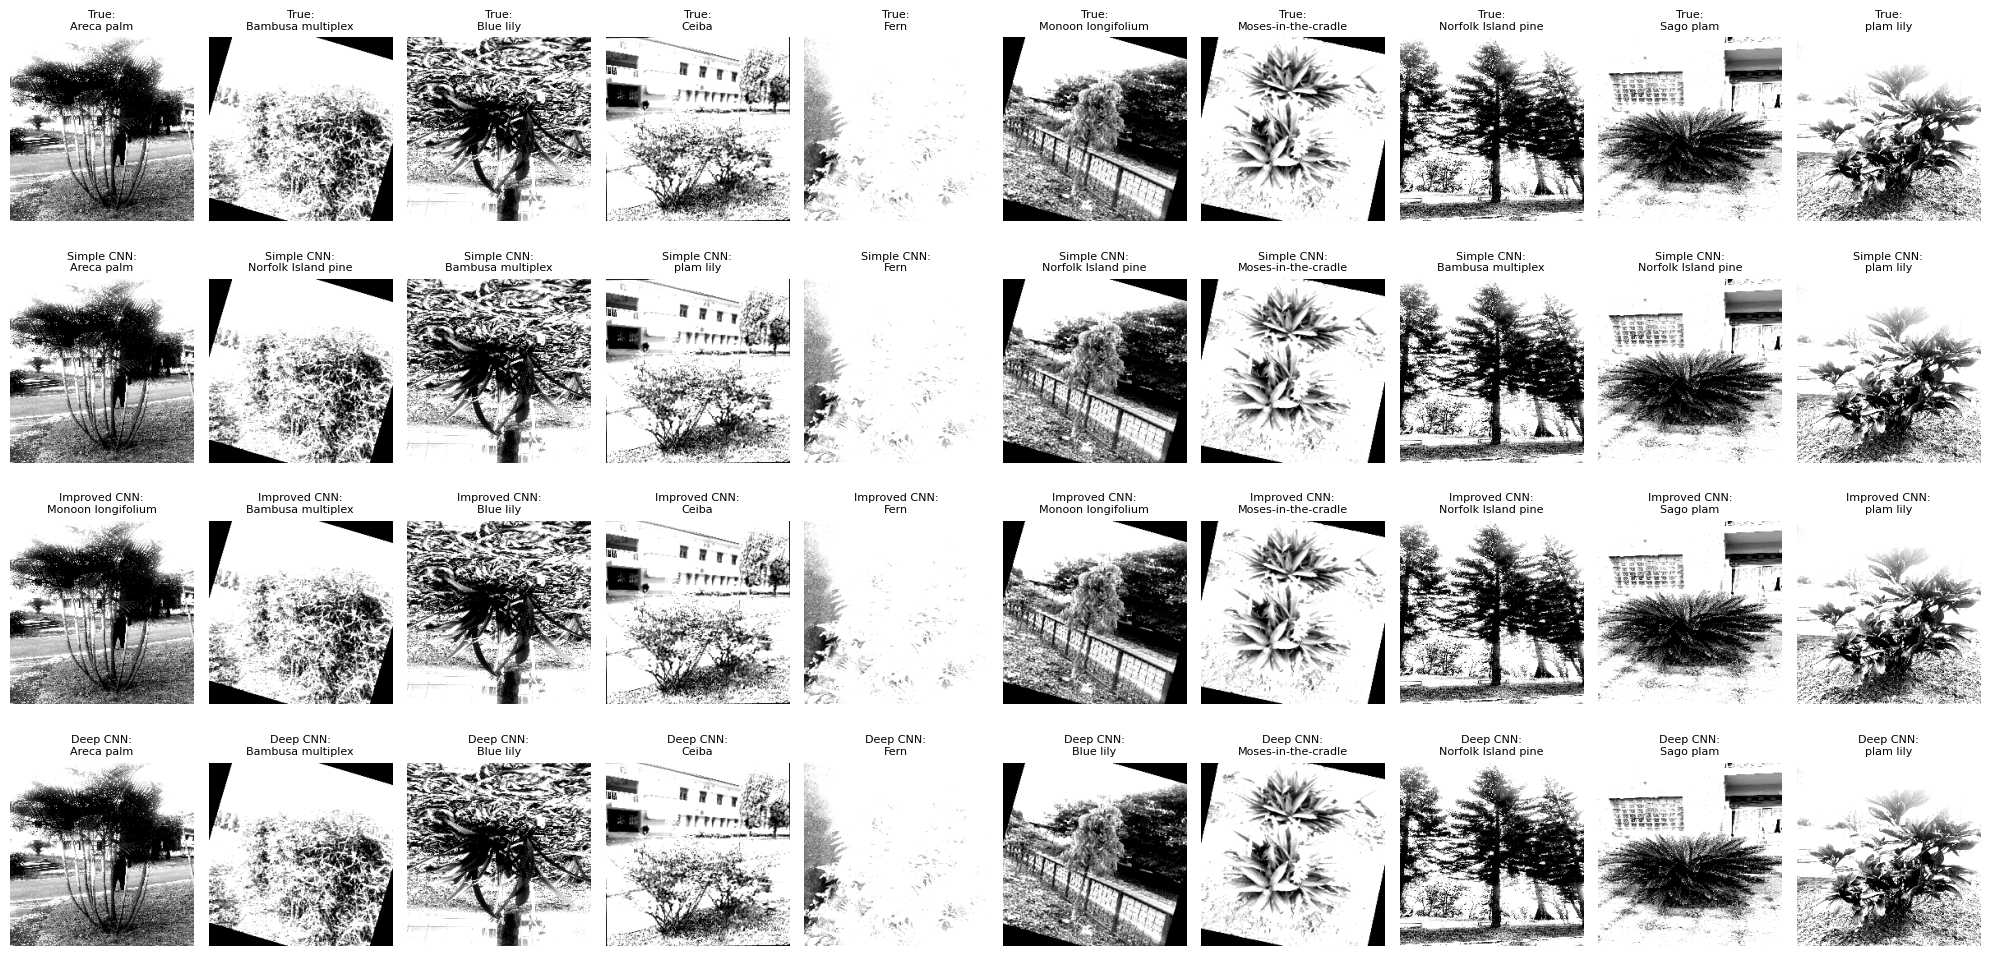

In [ ]:
# Models
models = [("Simple CNN", model1), ("Improved CNN", model2), ("Deep CNN", model3)]

# class names
class_names = test_dataset.dataset.classes

# Get one image per class
class_images = {}
class_labels = {}
for image, label in test_dataset:
    label_name = class_names[label]
    if label_name not in class_images:
        class_images[label_name] = image
        class_labels[label_name] = label
    if len(class_images) == len(class_names):
        break

# Sort by class name to have a consistent layout
sorted_classes = sorted(class_images.keys())

# Plotting: 4 rows (true + 3 models), 10 columns (one per class)
plt.figure(figsize=(20, 10))
for col_idx, class_name in enumerate(sorted_classes):
    image = class_images[class_name]
    img_np = image.permute(1, 2, 0).numpy().clip(0, 1)  # CxHxW → HxWxC

    # Row 0: true label
    plt.subplot(4, 10, col_idx + 1)
    plt.imshow(img_np)
    plt.title(f"True:\n{class_name}", fontsize=8)
    plt.axis('off')

    # Row 1–3: each model’s prediction
    for row_offset, (model_name, model) in enumerate(models):
        model.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_label_idx = output.argmax(dim=1).item()
            pred_class_name = class_names[pred_label_idx]

        subplot_idx = (row_offset + 1) * 10 + col_idx + 1
        plt.subplot(4, 10, subplot_idx)
        plt.imshow(img_np)
        plt.title(f"{model_name}:\n{pred_class_name}", fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()


This visualization showcases how each of the three models—Simple CNN, Improved CNN, and Deep CNN—performs on a sample image from each of the 10 plant classes.

The top row displays the ground truth (actual class label).

The following three rows show the predictions made by each model for the corresponding image.

This layout helps in qualitatively evaluating which models correctly predict the class and where they fail.

As observed, the Deep CNN model performs significantly better than the other two, especially on harder classes where the Simple CNN struggles.